# **Классификация: воспользуется ли клиент предложением банка об открытии депозита в будущем**

**Бизнес-задача:** определить характеристики, по которым можно выявить клиентов, более склонных к открытию депозита в банке, и за счёт этого повысить результативность маркетинговой кампании.

**Техническая задача:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import MinMaxScaler

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### ***Шаг 1***

In [2]:
df = pd.read_csv('/Users/kirillvolobuev/Documents/Python_study/Project_4_models.ipynb/bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [ ]:
# исследуем данные на предмет пропусков
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [4]:
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### ***Шаг 2***

In [5]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts().sort_values()

job
unknown            70
housemaid         274
entrepreneur      328
unemployed        357
student           360
self-employed     405
retired           778
services          923
admin.           1334
technician       1823
blue-collar      1944
management       2566
Name: count, dtype: int64

### ***Шаг 3***

In [ ]:
# преобразуем признак balance таким образом, чтобы он корректно считывался (как вещественное число (float))
df['balance'] = df['balance'].replace({',': '.', ' ': '', '\$': ''}, regex=True)
df['balance'] = df['balance'].astype(float)

print(round(df['balance'].mean(), 3))

1529.129


In [7]:
# проверим тип
df['balance'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 11162 entries, 0 to 11161
Series name: balance
Non-Null Count  Dtype  
--------------  -----  
11137 non-null  float64
dtypes: float64(1)
memory usage: 87.3 KB


In [8]:
# посмотрим на результат
df['balance']

0        2343.0
1          45.0
2        1270.0
3        2476.0
4         184.0
          ...  
11157       1.0
11158     733.0
11159      29.0
11160       0.0
11161       0.0
Name: balance, Length: 11162, dtype: float64

### ***Шаг 4***

In [ ]:
# обработаем пропуски в признаки balance, заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())
df['balance']

0        2343.0
1          45.0
2        1270.0
3        2476.0
4         184.0
          ...  
11157       1.0
11158     733.0
11159      29.0
11160       0.0
11161       0.0
Name: balance, Length: 11162, dtype: float64

In [ ]:
# Вычислите среднее значение по преобразованному в корректный вид признаку balance
round(df['balance'].mean(), 3)

np.float64(1526.936)

### ***Шаг 5***

In [ ]:
# обработаем пропуски в категориальных признаках: job и education, заменив их на модальные значения
d_job = df['job'].mode()[0]
d_edu = df['education'].mode()[0]

# отрегулируем unknown
df['job'] = df['job'].apply(lambda x: d_job if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: d_edu if x == 'unknown' else x)

In [ ]:
# После замены пропусков рассчитаем средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования 
# (т.е. для тех, у кого одновременно самая популярная работа и самое популярное образование)
mask_1 = df['job'].mode()[0]
mask_2 = df['education'].mode()[0]

result = df[(df['job'] == mask_1) & (df['education'] == mask_2)]['balance'].mean()
result = round(result, 3)
print(f"Результат: {result}")

Результат: 1598.883


### ***Шаг 6***

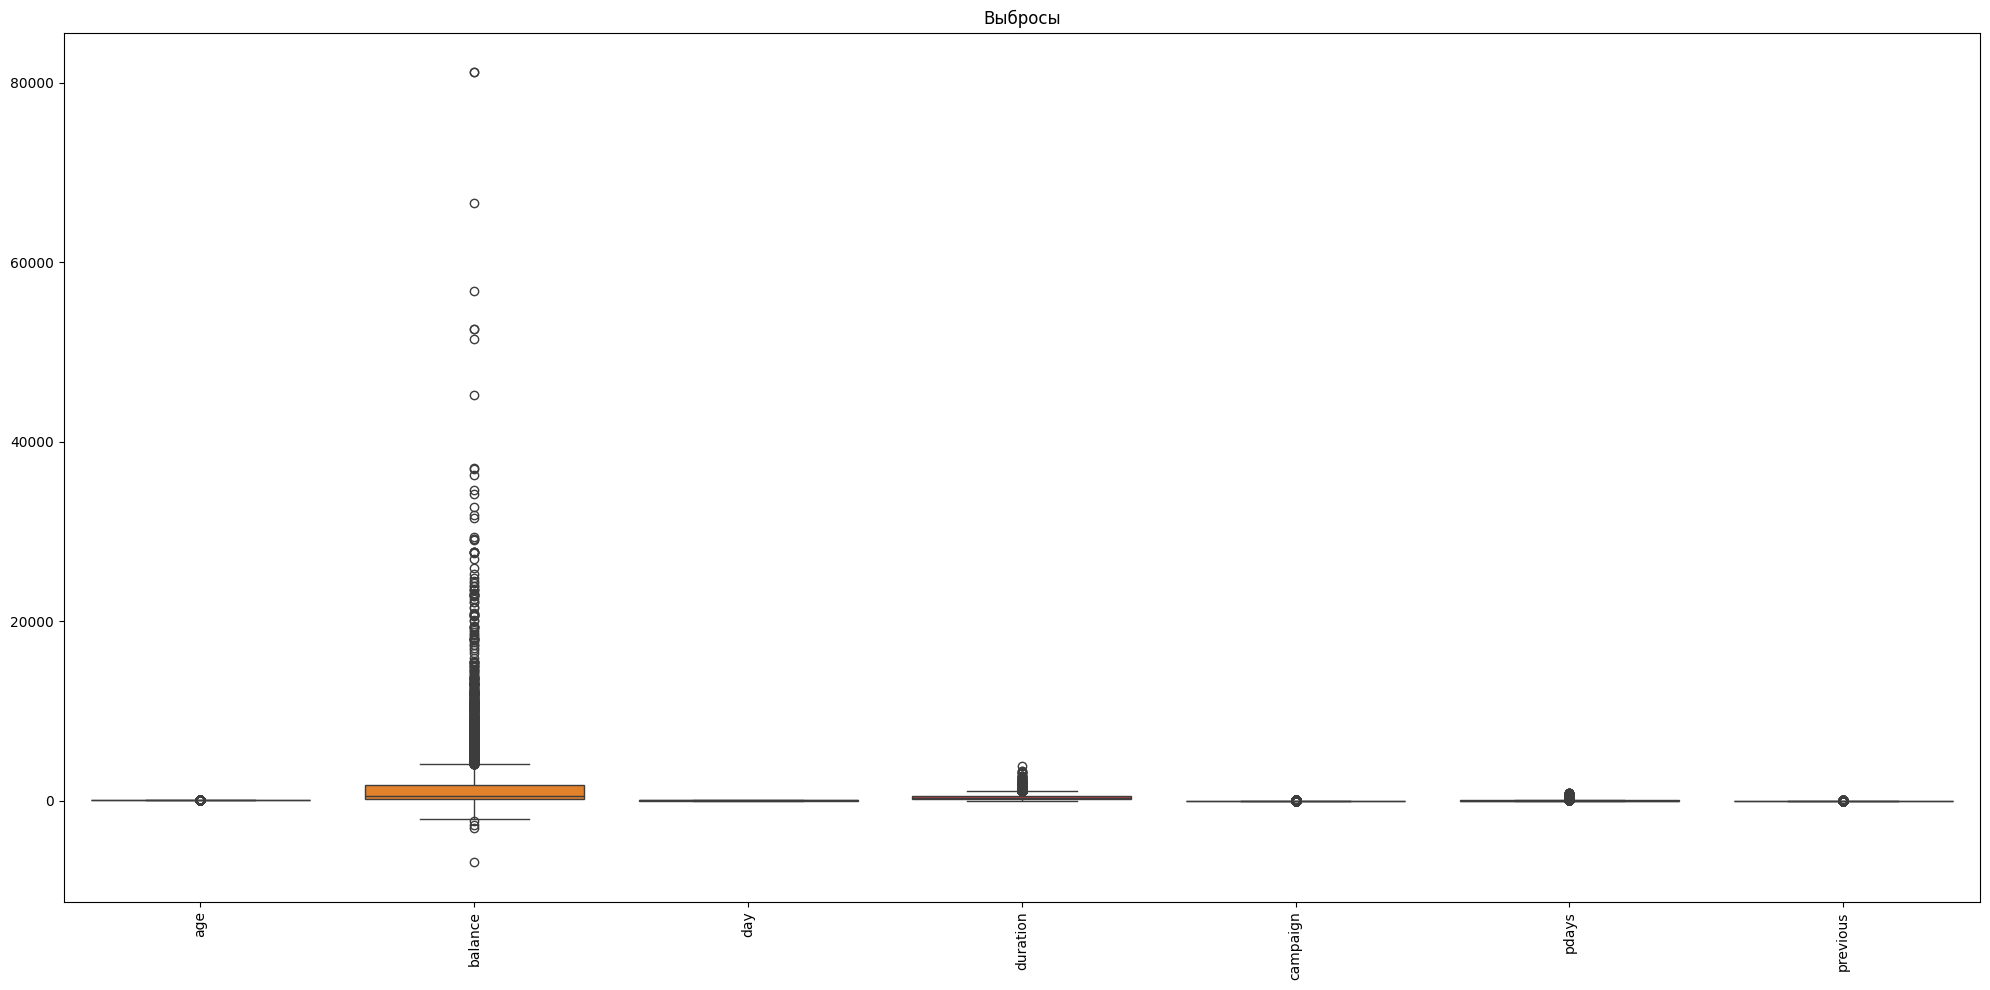

In [ ]:
# Визуализируем выбросы в данных
plt.figure(figsize=(20,10))
sns.boxplot(data=df)

plt.xticks(rotation = 90)
plt.title('Выбросы')
plt.tight_layout()
plt.show()

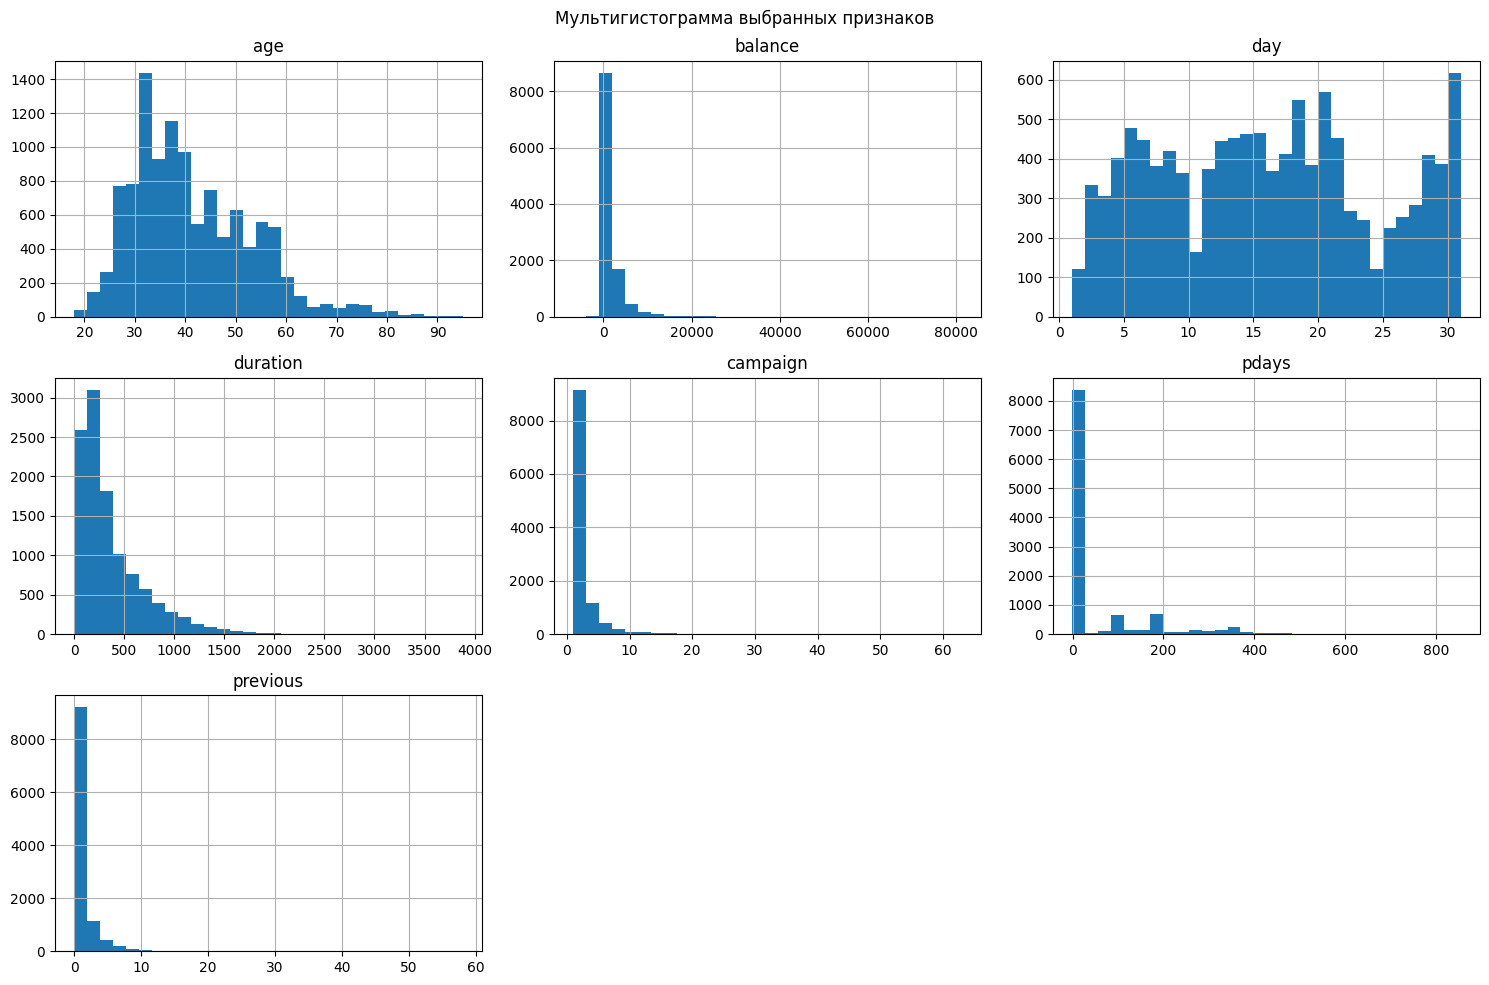

In [118]:
df.hist(bins=30, figsize=(15, 10))
plt.suptitle('Мультигистограмма выбранных признаков')
plt.tight_layout()
plt.show()

In [ ]:
# Применим метод Тьюки для удаления выбросов в нужной категории (balance)
Q1 = df['balance'].quantile(0.25)
Q3 = df['balance'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Удаляем строки с выбросами
df = df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)]

print(f'Lower bound: {lower_bound}')
print(f'Upper bound: {upper_bound}')
print(f'Осталось объектов: {len(df)}')

Lower bound: -2241.0
Upper bound: 4063.0
Осталось объектов: 10105


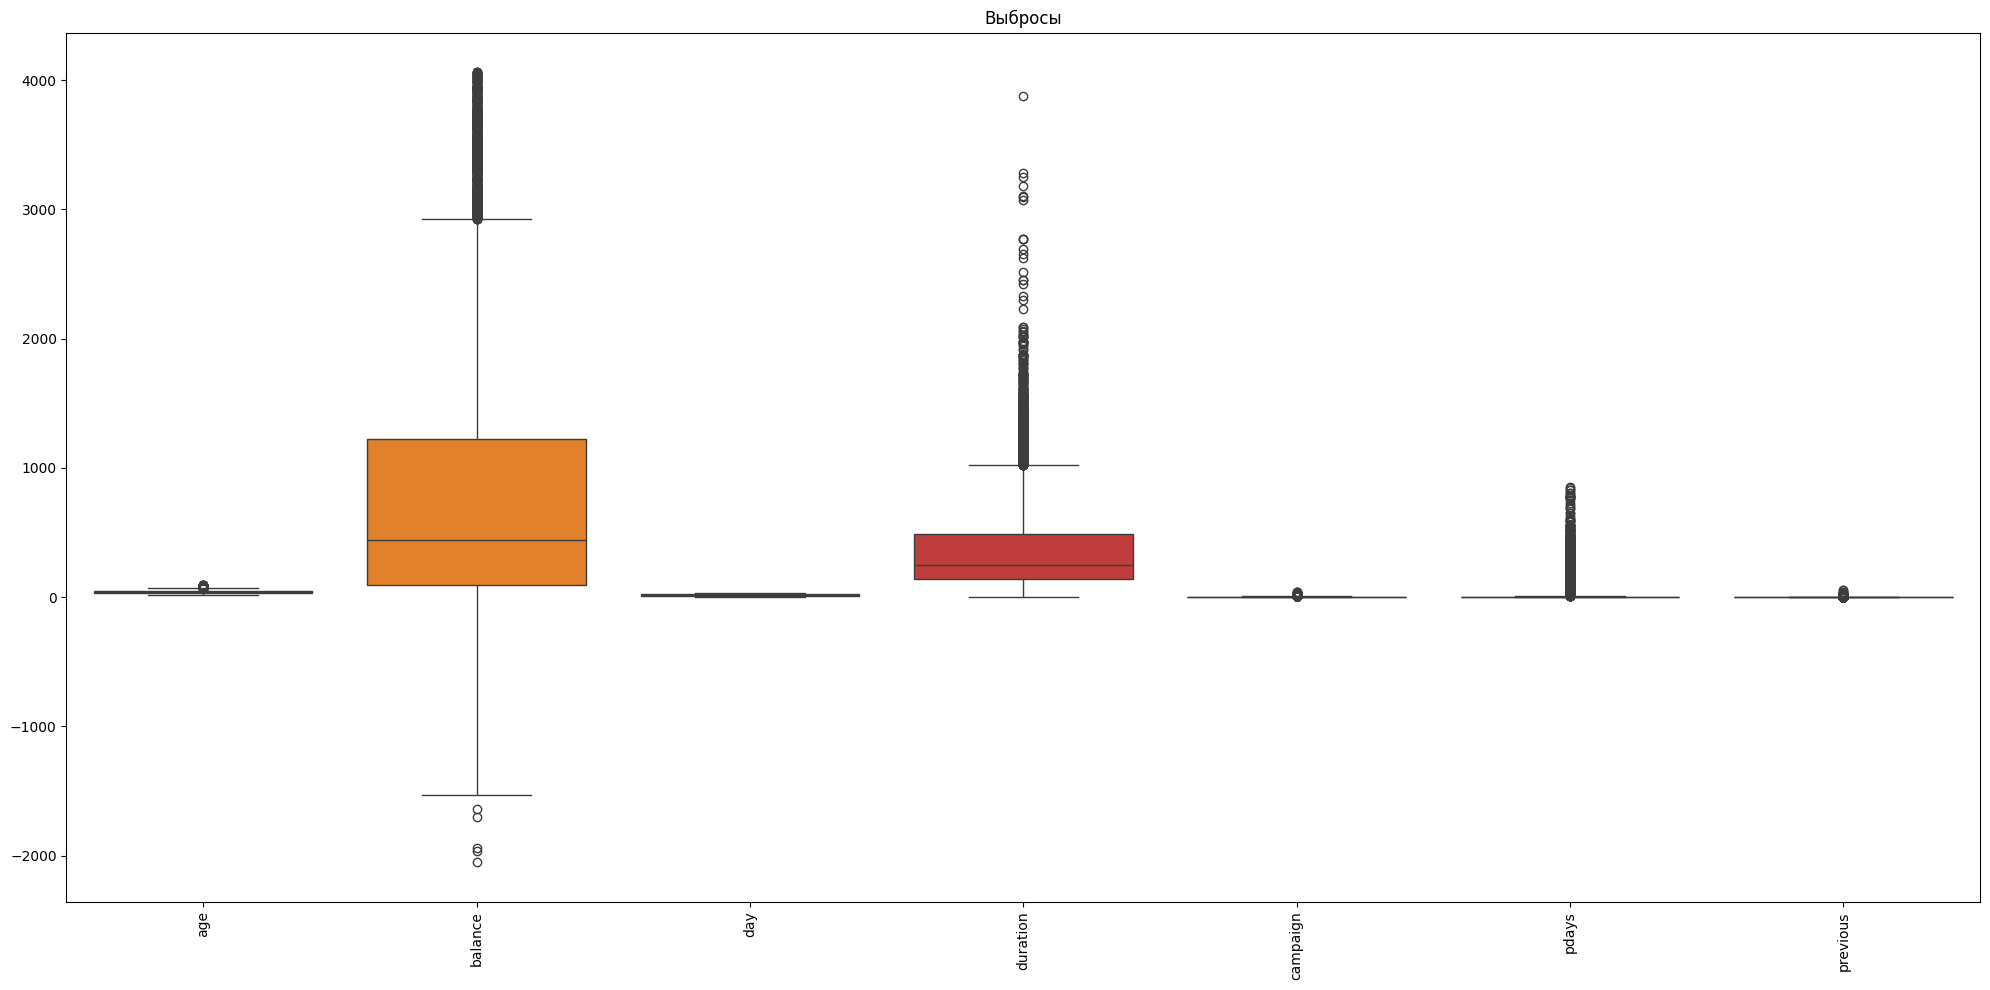

In [ ]:
# проверим выбросы (визуализируем)
plt.figure(figsize=(20,10))
sns.boxplot(data=df)

plt.xticks(rotation = 90)
plt.title('Выбросы')
plt.tight_layout()
plt.show()

## Часть 2:  Разведывательный анализ

### ***Шаг 1***

Text(0.5, 1.0, 'Распределение признака "deposit"')

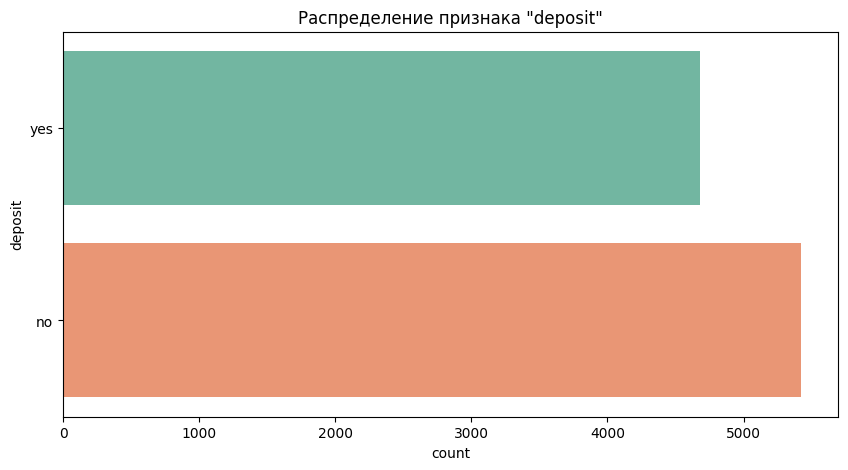

In [ ]:
# изучим соотношение классов в данных на предмет несбалансированности и проиллюстрируем результат (на переменной, которую необходимо предсказать)
df['deposit'].value_counts()
plt.figure(figsize=(10,5))
sns.countplot(df['deposit'], palette='Set2')
plt.title('Распределение признака "deposit"')

In [17]:
print(df['deposit'][df['deposit'] == 'yes'].count())

4681


### ***Шаг 2 и 3***

In [ ]:
# Рассчитаем описательные статистики для количественных переменных и проинтерпретируем результат
# Каков максимальный возраст клиента банка? Какова минимальная продолжительность разговора с клиентом банка?
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


### ***Шаг 4 и 5***

In [ ]:
# Рассчитаем описательные статистики для категориальных переменных и проинтерпретируем результат
# Сколько было месяцев, в которых проводилась маркетинговая кампания? Сколько сфер занятости представлено среди клиентов банка?
print(df['month'].nunique())
print(df['job'].nunique())

12
11


In [20]:
# Проверим еще раз
df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


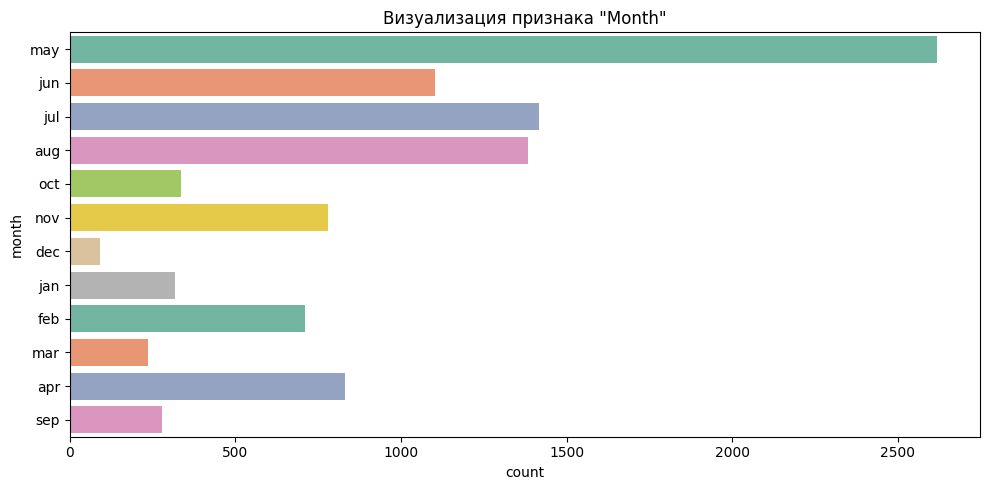

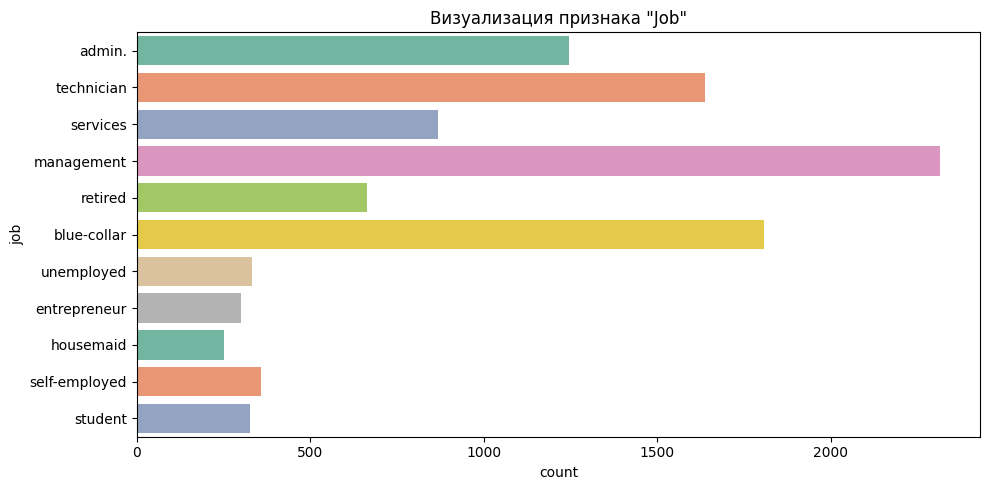

In [21]:
# визуализируем
plt.figure(figsize=(10, 5))
sns.countplot(df['month'], palette='Set2')
plt.title('Визуализация признака "Month"')
plt.tight_layout()
plt.figure(figsize=(10, 5))
sns.countplot(df['job'], palette='Set2')
plt.title('Визуализация признака "Job"')
plt.tight_layout()

plt.show()

### ***Шаг 6***

In [ ]:
# Узнаем, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
df['poutcome'].value_counts()

poutcome
unknown    7570
failure    1109
success     945
other       481
Name: count, dtype: int64

### ***Шаг 7***

In [ ]:
# узнаем, в каком месяце чаще всего отказывались от предложения открыть депозит
mask_p = df['poutcome'] == 'failure'
df[mask_p]['month'].value_counts()

month
may    335
apr    150
nov    139
feb    127
aug     84
oct     62
jun     48
sep     46
jul     42
jan     39
mar     26
dec     11
Name: count, dtype: int64

### ***Шаг 8***

In [ ]:
# создадим возрастные группы и определим, в каких группах более склонны открывать депозит, чем отказываться от предложения
age_cats = []

for i in df['age']:
    if i < 30:
        age_cats.append('<30')
    elif i <= 40:
        age_cats.append('30-40')
    elif i <= 50:
        age_cats.append('40-50')
    elif i <= 60:
        age_cats.append('50-60')
    else:
        age_cats.append('60+')

# добавляем категорию
df['age_categories'] = age_cats
display(df['age_categories'])

0        50-60
1        50-60
2        40-50
3        50-60
4        50-60
         ...  
11157    30-40
11158    30-40
11159    30-40
11160    40-50
11161    30-40
Name: age_categories, Length: 10105, dtype: object

In [25]:
# B каких группах более склонны открывать депозит, чем отказываться от предложения?
age_deposit = df.groupby('age_categories')['deposit'].apply(lambda x: (x == 'yes').mean())
display(age_deposit)

age_categories
30-40    0.426826
40-50    0.396896
50-60    0.425846
60+      0.810916
<30      0.591753
Name: deposit, dtype: float64

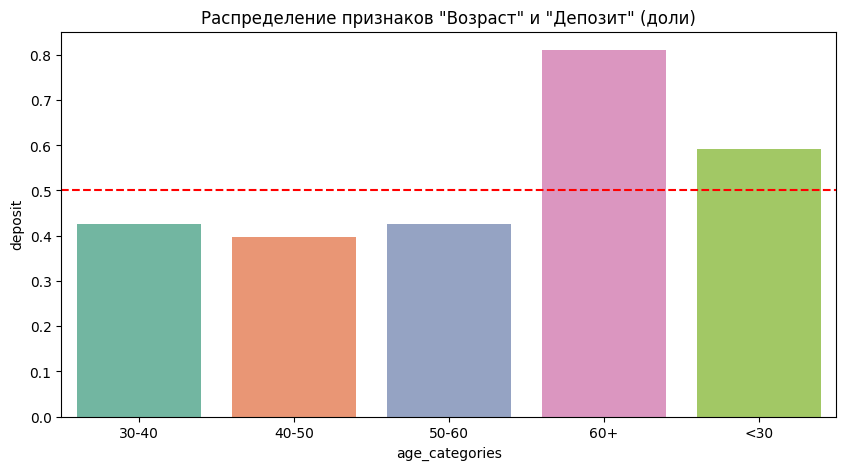

In [26]:
# визуализируем
plt.figure(figsize=(10,5))
sns.barplot(age_deposit, palette='Set2')
plt.axhline(y=0.5, color='red', linestyle='--')
plt.title('Распределение признаков "Возраст" и "Депозит" (доли)')

plt.show()

### ***Шаг 9 и 10***

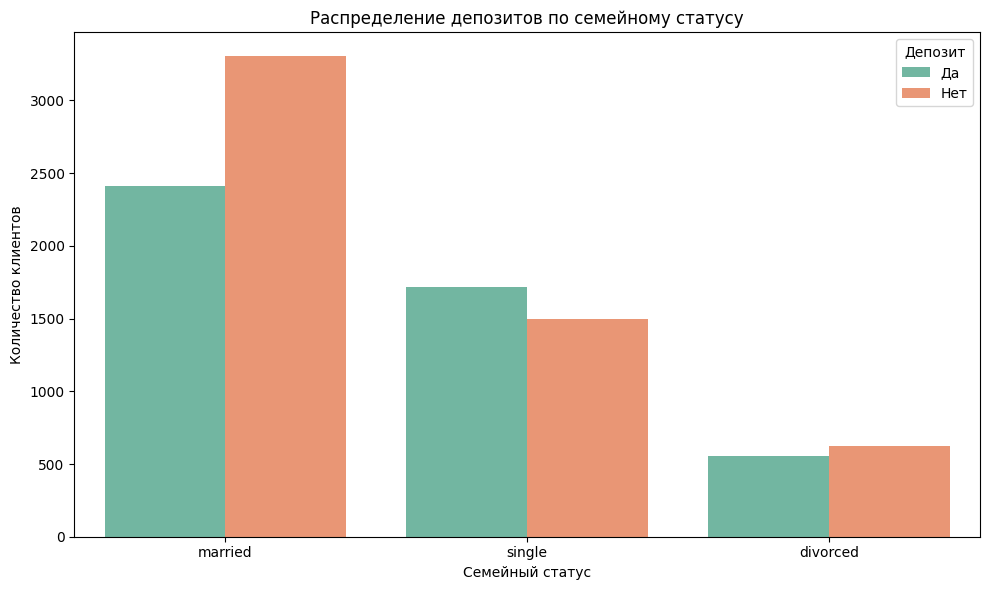

In [ ]:
# построим визуализацию для открывших и неоткрывших депозит в зависимости от семейного статуса
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='marital', hue='deposit', palette='Set2')
plt.title('Распределение депозитов по семейному статусу')
plt.xlabel('Семейный статус')
plt.ylabel('Количество клиентов')
plt.legend(title='Депозит', labels=['Да', 'Нет'])
plt.tight_layout()
plt.show()

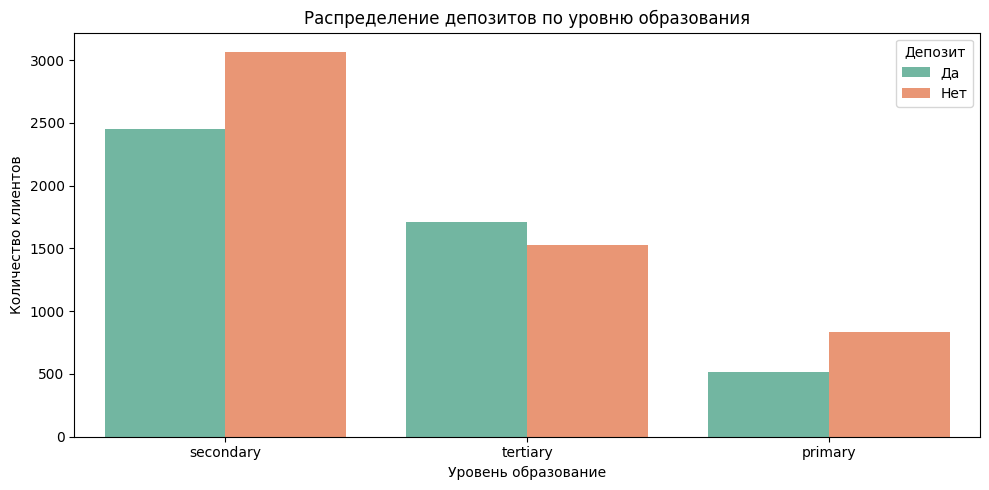

In [ ]:
# построим визуализацию для открывших и неоткрывших депозит в зависимости от образования
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='education', hue='deposit', palette='Set2')
plt.title('Распределение депозитов по уровню образования')
plt.xlabel('Уровень образование')
plt.ylabel('Количество клиентов')
plt.legend(title='Депозит', labels=['Да','Нет'])
plt.tight_layout()
plt.show()

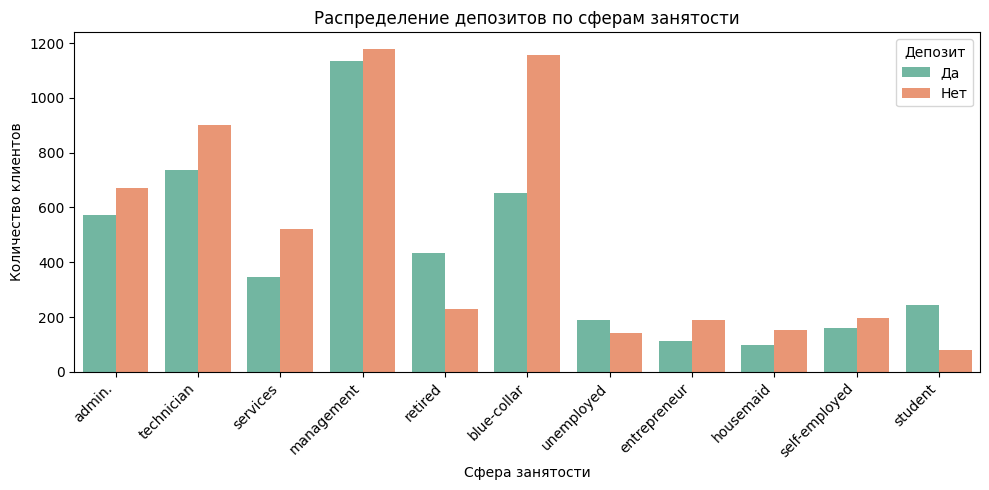

In [ ]:
# построим визуализацию для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='job', hue='deposit', palette='Set2')
plt.title('Распределение депозитов по сферам занятости')
plt.xlabel('Сфера занятости')
plt.ylabel('Количество клиентов')
plt.legend(title='Депозит', labels=['Да', 'Нет'])
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()

### ***Шаг 11***

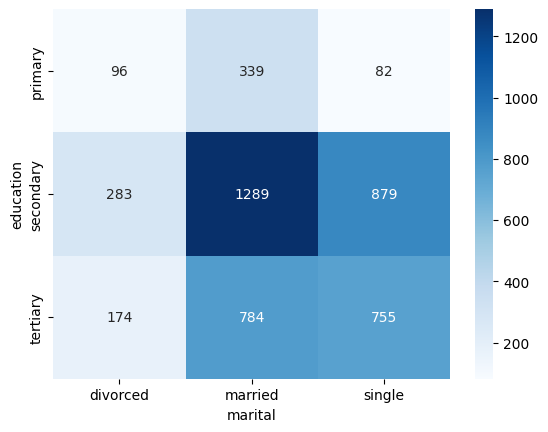

In [30]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
pivot = pd.crosstab(df[df['deposit'] == 'yes']['education'],
                    df[df['deposit'] == 'yes']['marital'])
sns.heatmap(pivot, annot=True, fmt='d', cmap='Blues')
plt.show()

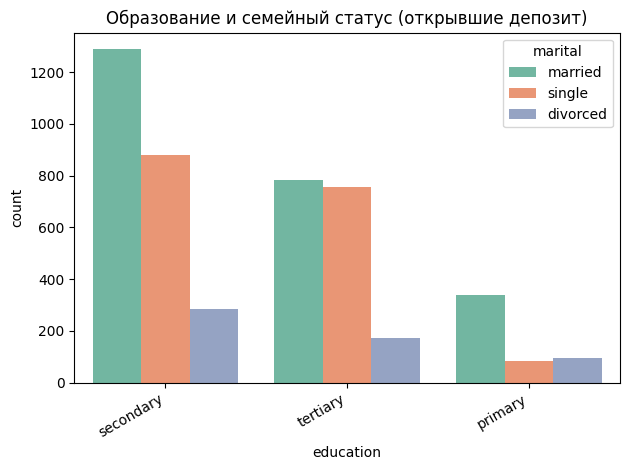

In [31]:
sns.countplot(
    data=df[df['deposit'] == 'yes'],
    x='education',
    hue='marital',
    palette='Set2'
)
plt.xticks(rotation=30, ha='right')
plt.title('Образование и семейный статус (открывшие депозит)')
plt.tight_layout()
plt.show()

## Часть 3: преобразование данных

### ***Шаг 1***

In [ ]:
# преобразуем уровни образования
df['education_coded'] = LabelEncoder().fit_transform(df['education'])
df.drop('education', axis=1, inplace=True)
df['education_coded'].sum()

np.int64(11995)

### ***Шаг 2 и 3***

In [ ]:
# преобразуем бинарные переменные в представление из нулей и единиц
df['age_coded'] = df['age_categories'].map({'<30':1, '30-40':2, '40-50':3, '50-60':4, '60+':5})
df['deposit_coded'] = df['deposit'].map({'no': 0, 'yes': 1})

In [34]:
df['default_coded'] = df['default'].map({'no': 0, 'yes': 1})
df['housing_coded'] = df['housing'].map({'no': 0, 'yes': 1})
df['loan_coded'] = df['loan'].map({'no': 0, 'yes': 1})

In [35]:
sum_of_three = round(df['default_coded'].mean() + df['housing_coded'].mean() + df['loan_coded'].mean(), 3)
print(sum_of_three)

0.635


### ***Шаг 4***

In [ ]:
# создадим дамми-переменные
df = pd.get_dummies(df, columns=['job', 'marital', 'contact', 'month', 'poutcome'], 
                    prefix=['job_coded', 'marital_coded', 'contact_coded', 'month_coded', 'poutcome_coded'], 
                    drop_first=False)



In [37]:
df.shape

(10105, 51)

In [ ]:
df.drop('default', axis=1, inplace=True)
df.drop('housing', axis=1, inplace=True)
df.drop('loan', axis=1, inplace=True)
df.drop('job', axis=1, inplace=True)
df.drop('marital', axis=1, inplace=True)
df.drop('contact', axis=1, inplace=True)
df.drop('month', axis=1, inplace=True)
df.drop('poutcome', axis=1, inplace=True)

In [46]:
df.drop('deposit', axis=1, inplace=True)

In [47]:
df.drop('age', axis=1, inplace=True)

In [48]:
df.drop('age_categories', axis=1, inplace=True)

### ***Шаг 5 и 6***

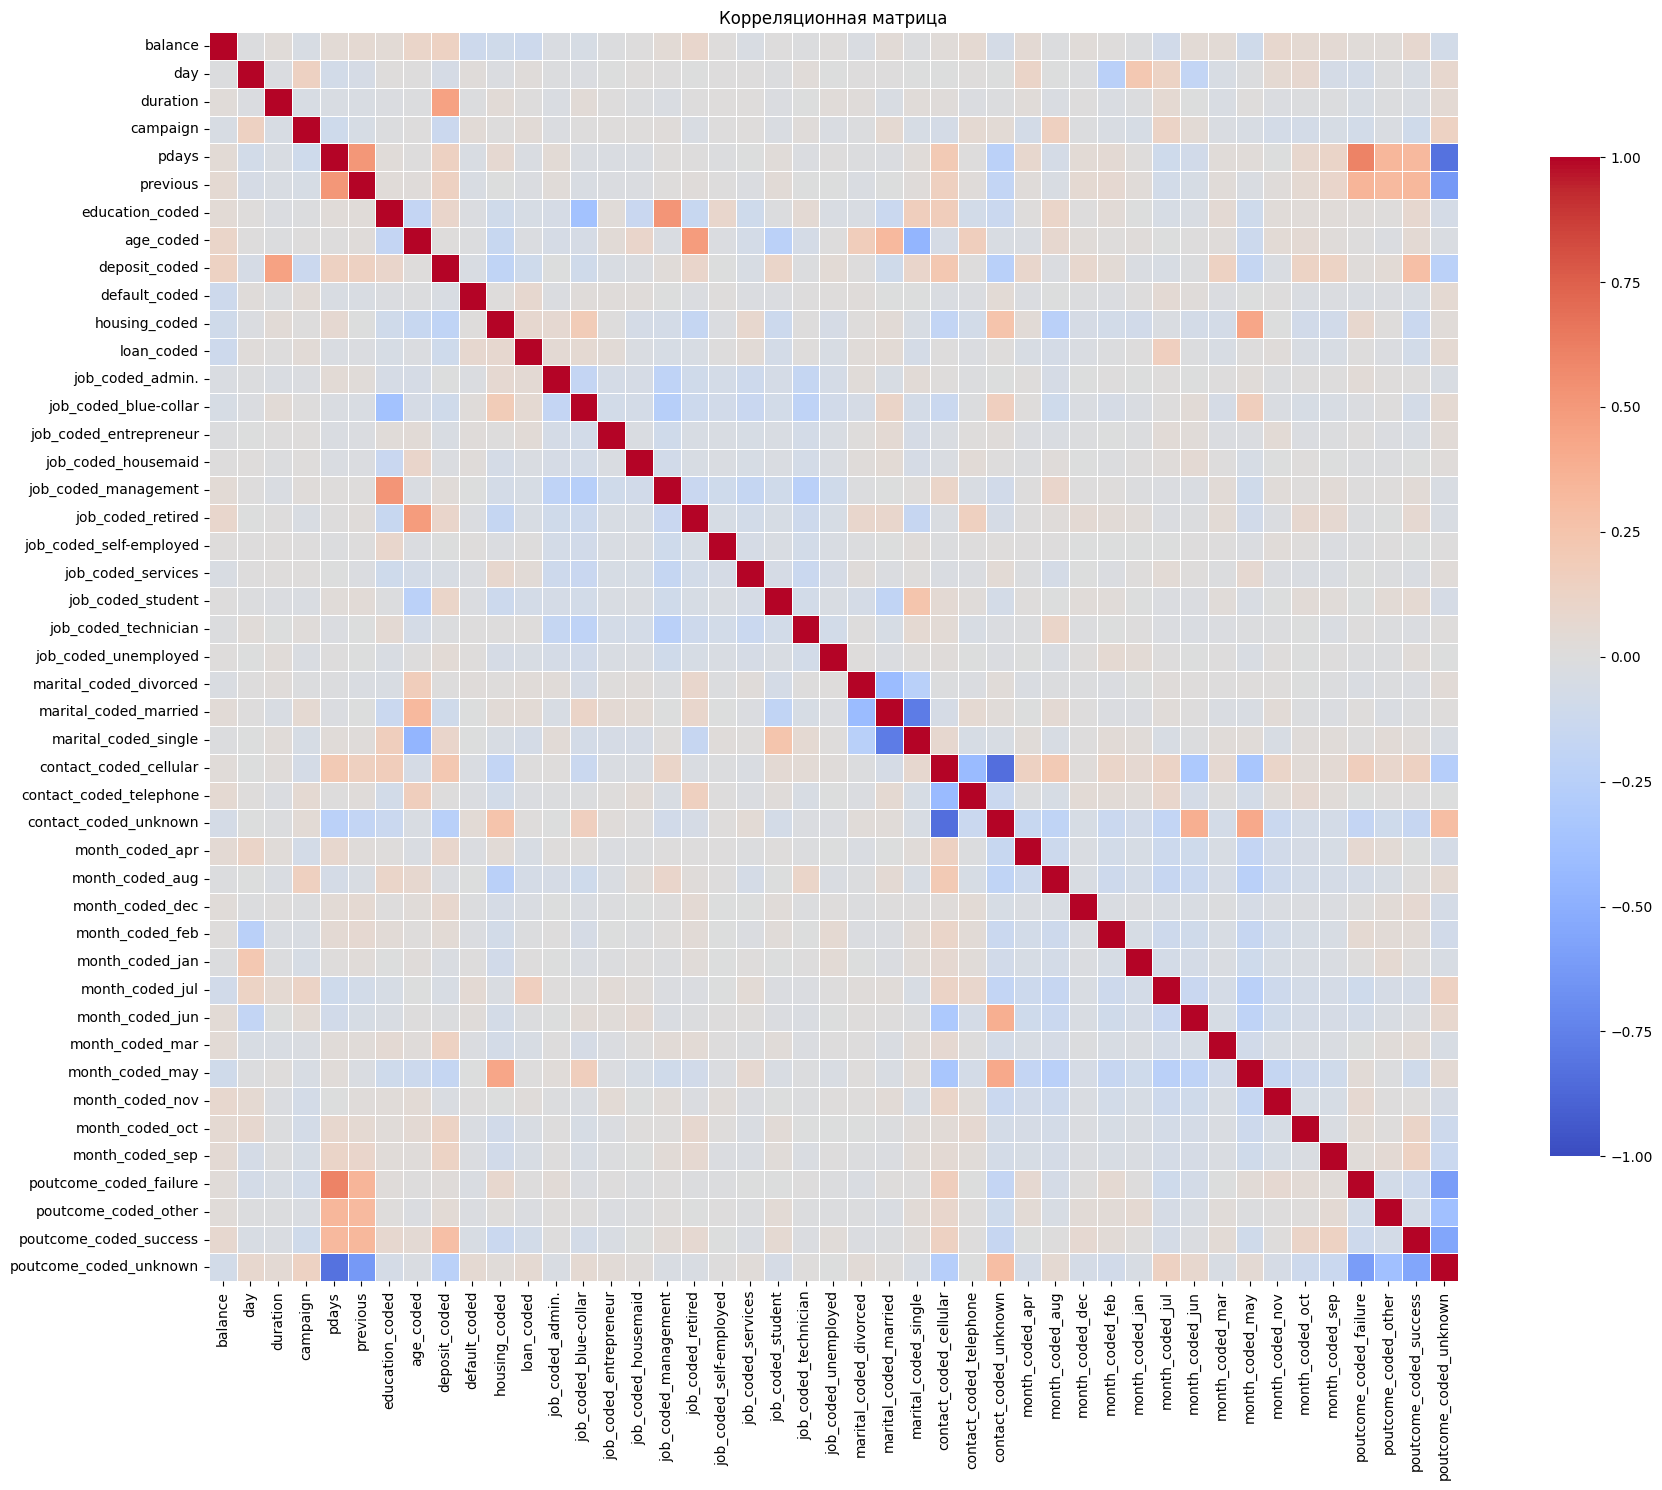

In [ ]:
# построим корреляционную матрицу и оценим данные на предмет наличия мультиколлинеарности
plt.figure(figsize=(20,15))
sns.heatmap(
    df.corr(),  
    annot=False,      
    cmap='coolwarm',  
    vmin=-1, vmax=1,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title('Корреляционная матрица')
plt.tight_layout()
plt.show()

### ***Шаг 7 и 8***

In [ ]:
# Разделим данные
X = df.drop(['deposit_coded'], axis=1)
y = df['deposit_coded']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [ ]:
# Размер тестовой выборки
X_test.shape

(3335, 44)

In [ ]:
# Каково среднее значение целевой переменной на тестовой выборке?
print(round(y_test.mean(), 2))

0.46


### ***Шаг 9***

In [ ]:
# с помощью SelectKBest отберем 15 наиболее подходящих признаков
selector = SelectKBest(score_func = f_classif, k=15)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

In [54]:
# Какие признаки отобраны?
mask = selector.get_support()
selected_features = X.columns[mask].tolist()
print("Отобранные признаки:", selected_features)

Отобранные признаки: ['balance', 'duration', 'campaign', 'pdays', 'previous', 'housing_coded', 'loan_coded', 'contact_coded_cellular', 'contact_coded_unknown', 'month_coded_mar', 'month_coded_may', 'month_coded_oct', 'month_coded_sep', 'poutcome_coded_success', 'poutcome_coded_unknown']


### ***Шаг 10***

In [ ]:
# нормализуем данные с помощью minmaxsxaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scalered = scaler.fit_transform(X_train)
X_test_scalered = scaler.transform(X_test)

In [ ]:
# Рассчитаем среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из тестовой выборки
print(round(X_train_scalered[:, 0].mean(), 2))

0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### ***Шаг 1***

In [ ]:
# обучим логистическую регрессию и рассчитаем метрики качества
log_reg = linear_model.LogisticRegression(max_iter=1000, random_state=42)

log_reg.fit(X_train_scalered, y_train)
y_train_pred = log_reg.predict(X_train_scalered)
print(metrics.classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85      3634
           1       0.85      0.79      0.82      3136

    accuracy                           0.84      6770
   macro avg       0.84      0.83      0.84      6770
weighted avg       0.84      0.84      0.84      6770



In [58]:
# теперь для тренировочной выборки
y_test_pred = log_reg.predict(X_test_scalered)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1790
           1       0.82      0.77      0.79      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### ***Шаг 2,3,4***

In [ ]:
# обучим решающие деревья, настроим максимальную глубину
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42)
tree.fit(X_train_scalered, y_train)

y_test_pred = tree.predict(X_test_scalered)
y_train_pred = tree.predict(X_train_scalered)

print("Accuracy(train)", metrics.accuracy_score(y_train, y_train_pred))
print("Accuracy(test)", metrics.accuracy_score(y_test, y_test_pred))

Accuracy(train) 0.8141802067946824
Accuracy(test) 0.7970014992503748


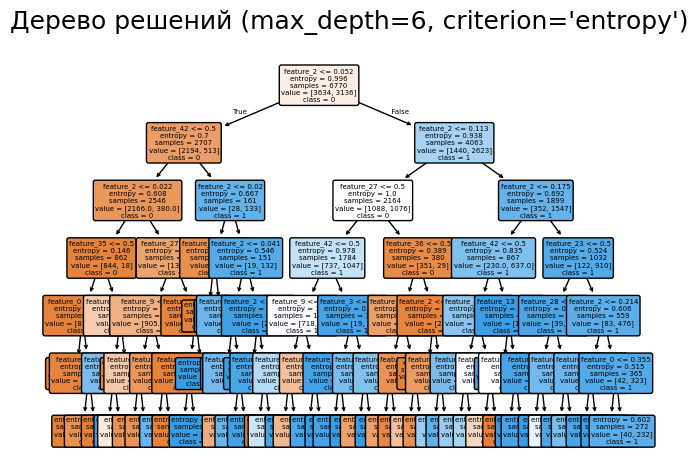

In [60]:
# Визуализация
from sklearn.tree import plot_tree

# Получаем названия классов из ваших данных
class_names = [str(cls) for cls in sorted(np.unique(y_train))]

# Получаем названия признаков (если были потеряны при масштабировании — создаём автоматически)
n_features = X_train_scalered.shape[1]
feature_names = [f'feature_{i}' for i in range(n_features)]

plot_tree(
    tree,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    rounded=True,
    fontsize=5
)

plt.title("Дерево решений (max_depth=6, criterion='entropy')", fontsize=18, pad=20)
plt.tight_layout()
plt.savefig('decision_tree.png', dpi=100, bbox_inches='tight')
plt.show()

### ***Шаг 5***

In [ ]:
# подберем оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
# определим сетку гиперпараметров
param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 7, 10]
}
# запускаем поиск лучшей комбинации с фокусом F1-score
grid = GridSearchCV(
    estimator=DecisionTreeClassifier(criterion='entropy', random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# обучаем на обучающей выборке
grid.fit(X_train_scalered, y_train)

# выведем лучшие параметры
print('Лучшие параметры:', grid.best_params_)

# предсказываем на тестовой выборке с лучшей моделью
y_test_pred = grid.best_estimator_.predict(X_test_scalered)

# рассчитываем F1 на тесте и округлим до 2 знаков
f1_test = metrics.f1_score(y_test, y_test_pred)
print(f"\nF1-score на тестовой выборке: {f1_test:.2f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for 

Лучшие параметры: {'max_depth': 7, 'min_samples_split': 5}

F1-score на тестовой выборке: 0.80


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### ***Шаг 1***

In [ ]:
# обучим на данных случайный лес
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=100,      
    criterion='gini',      
    min_samples_leaf=5,    
    max_depth=10,          
    random_state=42,       
    n_jobs=-1  
)
rf.fit(X_train_scalered, y_train)

# предсказываем
y_train_pred = rf.predict(X_train_scalered)
y_test_pred = rf.predict(X_test_scalered)

# посмотрим на метрики качества
print("=== Случайный лес ===")
print(f"Accuracy (train): {metrics.accuracy_score(y_train, y_train_pred):.4f}")
print(f"Accuracy (test):  {metrics.accuracy_score(y_test, y_test_pred):.4f}")
print(f"Recall (test):    {metrics.recall_score(y_test, y_test_pred):.4f}")
print(f"\nF1-score (test):  {metrics.f1_score(y_test, y_test_pred):.4f}")

=== Случайный лес ===
Accuracy (train): 0.8743
Accuracy (test):  0.8459
Recall (test):    0.8589

F1-score (test):  0.8378


### ***Шаг 2 и 3***

In [ ]:
# используем для классификации градиентный бустинг и сравним качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

# Создаём и обучаем модель градиентного бустинга
gb = GradientBoostingClassifier(
    learning_rate=0.05,    
    n_estimators=300,      
    min_samples_leaf=5,    
    max_depth=5,           
    random_state=42
)

gb.fit(X_train_scalered, y_train)

# Предсказания на тестовой выборке
y_test_pred_gb = gb.predict(X_test_scalered)

# Расчёт F1-score и вывод ответа для задания
f1_gb = metrics.f1_score(y_test, y_test_pred_gb)
print(f"F1-score (Gradient Boosting) на тесте: {f1_gb:.4f}")
print(f"\n>>> Показатель: {round(f1_gb, 2):.2f}")

F1-score (Gradient Boosting) на тесте: 0.8454

>>> Показатель: 0.85


### ***Шаг 4***

In [ ]:
# объединим уже известные алгоритмы с помощью стекинга
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Базовые модели с параметрами из предыдущих шагов
base_models = [
    ('decision_tree', DecisionTreeClassifier(
        criterion='entropy', 
        max_depth=6, 
        random_state=42
    )),
    ('logistic_regression', LogisticRegression(
        max_iter=1000, 
        random_state=42
    )),
    ('gradient_boosting', GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
    ))
]

# Метамодель: логистическая регрессия (те же параметры)
meta_model = LogisticRegression(max_iter=1000, random_state=42)

# Создаём стекинг
stacking = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,          
    n_jobs=-1    
)

# Обучаем ансамбль
print("Обучение стекинга (может занять 3-7 минут)...")
stacking.fit(X_train_scalered, y_train)

# Предсказания и метрика
y_test_pred = stacking.predict(X_test_scalered)
precision = metrics.precision_score(y_test, y_test_pred)

# Вывод результата для задания
print(f"\nPrecision (Stacking) на тесте: {precision:.4f}")
print(f"\n>>> Показатель {round(precision, 2):.2f}") 

Обучение стекинга (может занять 3-7 минут)...


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for 


Precision (Stacking) на тесте: 0.8297

>>> Показатель 0.83


### ***Шаг 5***

=== Топ-10 самых важных признаков ===
               Признак  Важность
              duration  0.449158
poutcome_coded_success  0.109903
 contact_coded_unknown  0.068891
                 pdays  0.043535
                   day  0.043202
         housing_coded  0.042095
               balance  0.030710
             age_coded  0.030263
       month_coded_mar  0.025456
       month_coded_jun  0.018873


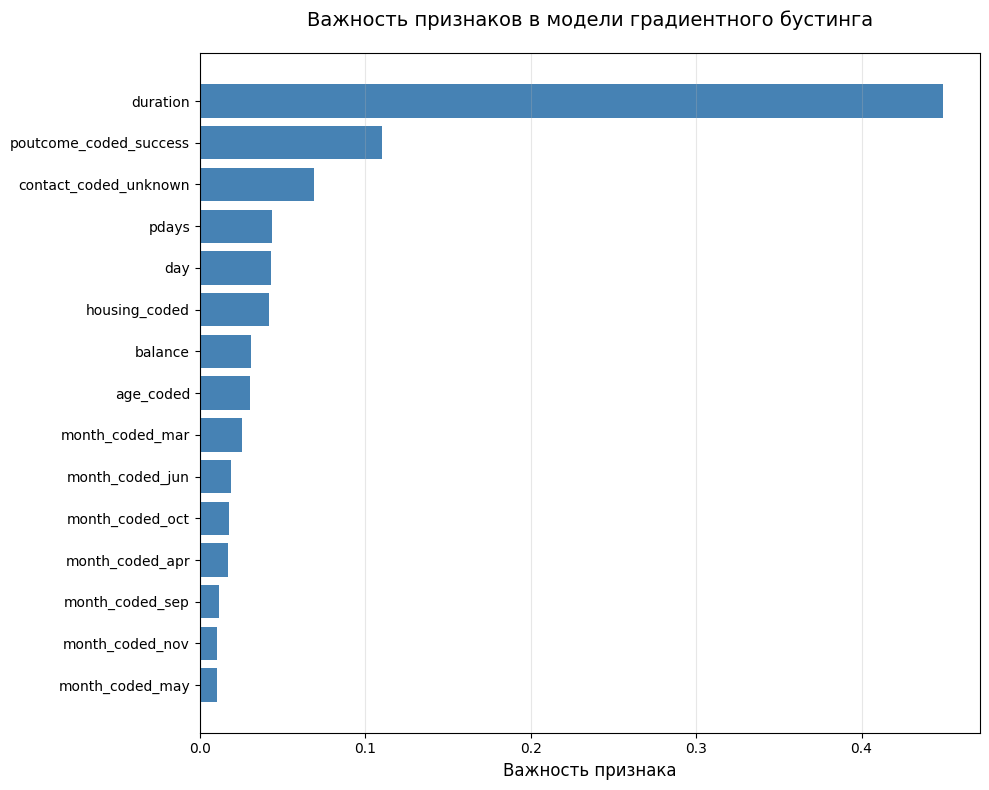

In [ ]:
# оценим, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
import pandas as pd
import matplotlib.pyplot as plt

# 1. Получаем важности признаков из обученной модели градиентного бустинга
importances = gb.feature_importances_  # gb — наша обученная модель GradientBoostingClassifier

# 2. Получаем названия признаков (из исходного датасета ДО масштабирования!)
if hasattr(X_train, 'columns'):
    feature_names = X_train.columns.tolist()
else:
    # Если названий нет — создаём искусственные
    feature_names = [f'feature_{i}' for i in range(len(importances))]

# 3. Создаём таблицу и сортируем по убыванию важности
feature_importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность': importances
}).sort_values(by='Важность', ascending=False)

# 4. Выводим топ-10 признаков
print("=== Топ-10 самых важных признаков ===")
print(feature_importance_df.head(10).to_string(index=False))

# 5. Визуализация (горизонтальная диаграмма)
plt.figure(figsize=(10, 8))
plt.barh(
    feature_importance_df['Признак'][:15][::-1],  # топ-15, переворачиваем для красоты
    feature_importance_df['Важность'][:15][::-1],
    color='steelblue'
)
plt.xlabel('Важность признака', fontsize=12)
plt.title('Важность признаков в модели градиентного бустинга', fontsize=14, pad=20)
plt.tight_layout()
plt.grid(axis='x', alpha=0.3)
plt.savefig('feature_importance.png', dpi=100, bbox_inches='tight')
plt.show()

### ***Шаг 6,7,8***

In [ ]:
# реализуем оптимизацию гиперпараметров с помощью Optuna
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn import metrics

# 1. Функция для оптимизации (возвращает средний F1 на кросс-валидации)
def objective(trial):
    # Предлагаем гиперпараметры в заданных диапазонах
    n_estimators = trial.suggest_int('n_estimators', 100, 200, step=1)
    max_depth = trial.suggest_int('max_depth', 10, 30, step=1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, step=1)
    
    # Создаём модель
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        criterion='gini',
        random_state=42,
        n_jobs=-1
    )
    
    # Кросс-валидация на ОБУЧАЮЩИХ данных (5 фолдов, стратифицированно)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(
        model, 
        X_train_scalered, 
        y_train, 
        cv=cv, 
        scoring='f1',  
        n_jobs=-1
    )
    return scores.mean()  

# 2. Запуск оптимизации
print("Запуск оптимизации гиперпараметров через Optuna (50 итераций)...")
study = optuna.create_study(direction='maximize')  
study.optimize(
    objective, 
    n_trials=50, 
    show_progress_bar=True,  
    n_jobs=-1                
)

# 3. Вывод лучших параметров
print("\n Лучшие гиперпараметры:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")
print(f"Лучший F1 на кросс-валидации: {study.best_value:.4f}")

# 4. Обучение финальной модели на ВСЕЙ обучающей выборке
best_model = RandomForestClassifier(
    **study.best_params,
    criterion='gini',
    random_state=42,
    n_jobs=-1
)
best_model.fit(X_train_scalered, y_train)

# 5. Оценка на ТЕСТОВОЙ выборке (данные, которые модель НИКОГДА не видела)
y_test_pred = best_model.predict(X_test_scalered)
f1_test = metrics.f1_score(y_test, y_test_pred)

# 6. Финальный ответ для задания
print(f"\n F1-score на тестовой выборке: {f1_test:.4f}")
print(f"\n>>> Показатель: {round(f1_test, 2):.2f}")

[I 2026-02-16 15:14:30,751] A new study created in memory with name: no-name-6e7f2640-b9eb-4d50-9d07-cf228ca5ea79


Запуск оптимизации гиперпараметров через Optuna (50 итераций)...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-16 15:14:31,934] Trial 3 finished with value: 0.8396645758281158 and parameters: {'n_estimators': 161, 'max_depth': 15, 'min_samples_leaf': 10}. Best is trial 3 with value: 0.8396645758281158.
[I 2026-02-16 15:14:31,998] Trial 1 finished with value: 0.8439066237704536 and parameters: {'n_estimators': 125, 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8439066237704536.
[I 2026-02-16 15:14:32,485] Trial 0 finished with value: 0.8341808354969862 and parameters: {'n_estimators': 167, 'max_depth': 10, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.8439066237704536.
[I 2026-02-16 15:14:32,928] Trial 6 finished with value: 0.8439625868798215 and parameters: {'n_estimators': 121, 'max_depth': 23, 'min_samples_leaf': 4}. Best is trial 6 with value: 0.8439625868798215.
[I 2026-02-16 15:14:33,243] Trial 5 finished with value: 0.8416146247322327 and parameters: {'n_estimators': 178, 'max_depth': 11, 'min_samples_leaf': 3}. Best is trial 6 with value: 0.84